In [1]:
# %pip install pillow==2.2.1
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D, LeakyReLU,BatchNormalization, Add,Dropout
from tensorflow.keras.models import Model
from segmentation_models.metrics import IOUScore
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy,SparseCategoricalCrossentropy


Segmentation Models: using `keras` framework.


In [2]:
import tensorflow as tf
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


2.10.1
Num GPUs Available:  1


In [3]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import random
import tensorflow as tf
from PIL import Image

# import tensorflow_addons as tfa


In [4]:
train_img_dir = "data/data_for_keras_aug/train_images/train/"
train_mask_dir = "data/data_for_keras_aug/train_masks/train/"

In [5]:
img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

In [6]:
num_images = len(os.listdir(train_img_dir))

In [7]:
img_num = random.randint(0, num_images-1)

In [8]:
img_for_plot = cv2.imread(train_img_dir+img_list[img_num], 1)
img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

In [9]:
mask_for_plot =cv2.imread(train_mask_dir+msk_list[img_num], 0)

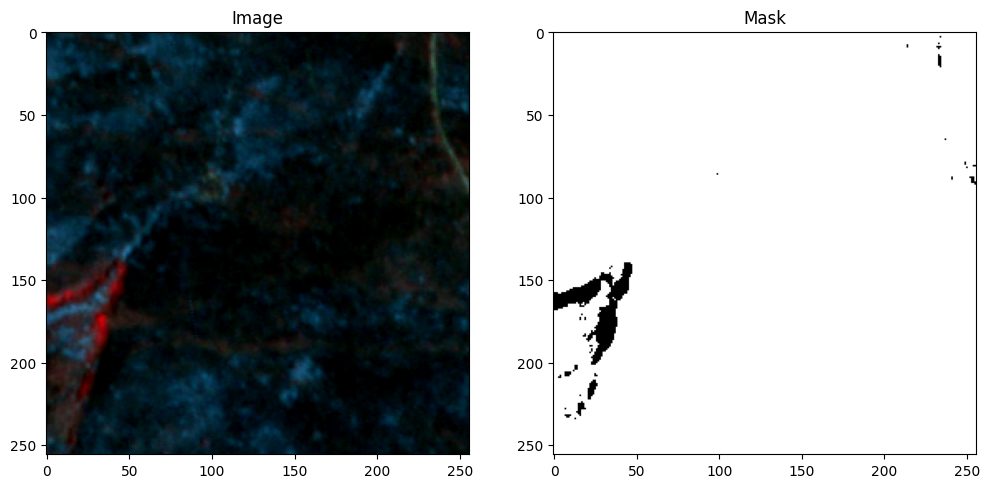

In [10]:
plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()


## Defining seed size

In [11]:
seed=24
batch_size= 8
n_classes=2

In [12]:
# %pip install -U scikit-learn

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from keras.utils import to_categorical

## Backbone

In [14]:
#Use this to preprocess input for transfer learning
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

## Preprocessing

In [15]:

def preprocess_data(img, mask, num_class):
    #Scale images
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    img = preprocess_input(img)  #Preprocess based on the pretrained backbone...
    #Convert mask to one-hot
    mask = mask / 255.0  # Normalize mask values to [0, 1]
    mask = to_categorical(mask, num_class)
      
    return (img,mask)

In [16]:
# from tensorflow.keras.applications.vgg16 import preprocess_input
# from tensorflow.keras.utils import to_categorical
# import numpy as np

# def preprocess_data(img, mask, num_class):
#     # Scale images
#     img = img.astype(np.float32)  # Ensure the image is in float32 format
#     img = preprocess_input(img)   # Preprocess based on the VGG16 model requirements
    
#     # Convert mask to one-hot
#     mask = mask / 255.0  # Normalize mask values to [0, 1]
#     mask = to_categorical(mask, num_class)
      
#     return (img, mask)


In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Train Generator

In [18]:
def trainGenerator(train_img_path, train_mask_path, num_class):
    
    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        color_mode = 'grayscale',
        batch_size = batch_size,
        seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)

In [19]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler  # Assuming StandardScaler is used

# def preprocess_data(img, mask, num_class):
#     scaler = StandardScaler()
#     # Scale images
#     img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
#     img = preprocess_input(img)  # Preprocess based on the pretrained backbone
    
#     # Normalize mask values to [0, 1] and convert to one-hot encoding
#     mask = mask / 255.0
#     mask = to_categorical(mask, num_class)
      
#     return img, mask

def trainGenerator(train_img_path, train_mask_path, num_class):
    img_data_gen_args = dict(
        horizontal_flip=True,
        vertical_flip=True,
        rotation_range=30,           # Random rotations
        width_shift_range=0.1,       # Random width shifts
        height_shift_range=0.1,      # Random height shifts
        zoom_range=0.2,              # Random zoom
        fill_mode='reflect'
    )
    
    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)
    
    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        target_size=(256, 256),  # Adjust based on your model input size
        color_mode='rgb',        # Assuming RGB images
        class_mode=None,
        batch_size=batch_size,
        seed=seed)
    
    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        target_size=(256, 256),  # Adjust based on your model input size
        color_mode='grayscale',
        class_mode=None,
        batch_size=batch_size,
        seed=seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield img, mask


In [20]:
train_img_path = "data/data_for_keras_aug/train_images/"
train_mask_path = "data/data_for_keras_aug/train_masks/"
train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=2)

In [21]:
x, y = train_img_gen.__next__()

Found 105 images belonging to 1 classes.
Found 105 images belonging to 1 classes.


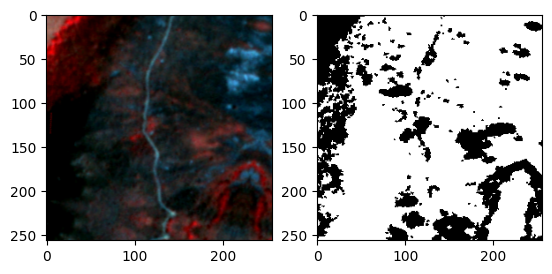

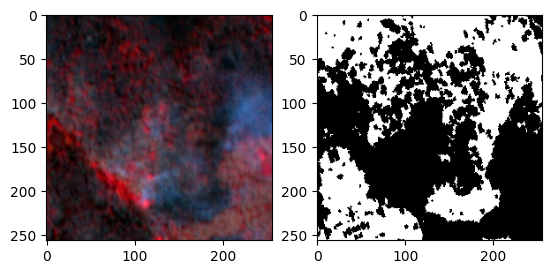

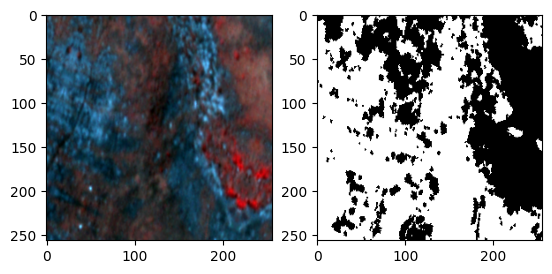

In [22]:
for i in range(0,3):
    image = x[i]
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()

In [23]:
val_img_path = "data/data_for_keras_aug/val_images/"
val_mask_path = "data/data_for_keras_aug/val_masks/"
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=2)

In [24]:
x_val, y_val = val_img_gen.__next__()

Found 35 images belonging to 1 classes.
Found 35 images belonging to 1 classes.


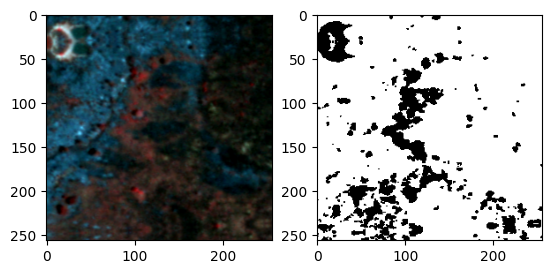

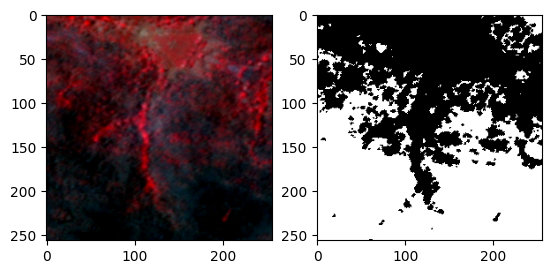

In [25]:
for i in range(0,2):
    image = x_val[i]
    mask = np.argmax(y_val[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.show()

In [26]:
num_train_imgs = len(os.listdir('data/data_for_keras_aug/train_images/train/'))
num_val_images = len(os.listdir('data/data_for_keras_aug/val_images/val/'))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size

In [27]:
IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]


In [28]:
IMG_CHANNELS

3

In [29]:
y.shape[3]

2

In [30]:
n_classes=2

### Custom Loss

In [31]:
import tensorflow as tf


class DiceLoss(tf.keras.losses.Loss):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def call(self, y_true, y_pred):
        intersection = tf.reduce_sum(y_true * y_pred)
        union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
        dice = (2.0 * intersection + 1e-7) / (union + 1e-7)
        return 1.0 - dice  


def custom_loss(y_true, y_pred):
    y_true_float = tf.cast(y_true, tf.float32)
    dice_loss = DiceLoss()(y_true_float, y_pred)
    l2_reg = 0.01  
    l2_loss = l2_reg * tf.reduce_sum([tf.reduce_mean(tf.square(w)) for w in tf.compat.v1.trainable_variables()])
    focal_loss_value = sm.losses.categorical_focal_loss(y_true, y_pred)
    combined_loss = dice_loss + l2_loss
    
    return combined_loss


### Total Loss

In [32]:

dice_loss = sm.losses.DiceLoss() 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

### Modified Combined Loss

In [33]:
class DiceLoss(tf.keras.losses.Loss):
    def __init__(self):
        super(DiceLoss, self).__init__()

    def call(self, y_true, y_pred):
        # Ensure predictions are probabilities
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1.0 - 1e-7)
        intersection = tf.reduce_sum(y_true * y_pred)
        union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
        dice = (2.0 * intersection + 1e-7) / (union + 1e-7)
        return 1.0 - dice

# Focal Loss Implementation
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        alpha = tf.constant(alpha, dtype=tf.float32)
        gamma = tf.constant(gamma, dtype=tf.float32)
        cross_entropy = -y_true * tf.math.log(y_pred)
        focal_loss = alpha * tf.math.pow(1 - y_pred, gamma) * cross_entropy
        return tf.reduce_sum(focal_loss, axis=-1)
    return focal_loss_fixed

# Custom Loss Function
def custom_loss(y_true, y_pred):
    y_true_float = tf.cast(y_true, tf.float32)
    dice_loss = DiceLoss()(y_true_float, y_pred)
    
    # L2 Regularization
    l2_reg = 0.01
    l2_loss = l2_reg * tf.reduce_sum([tf.reduce_mean(tf.square(w)) for w in tf.compat.v1.trainable_variables()])

    # Focal Loss
    focal_loss_value = focal_loss(gamma=2.0, alpha=0.25)(y_true_float, y_pred)
    
    # Combine Dice Loss, Focal Loss, and L2 Loss
    combined_loss = dice_loss + focal_loss_value + l2_loss
    
    return combined_loss

## Weighted cross entropy Loss

In [34]:
# import tensorflow as tf


# class WeightedCrossEntropyLoss(tf.keras.losses.Loss):
#     def __init__(self, weight_pos=1.0, weight_neg=1.0):
#         super(WeightedCrossEntropyLoss, self).__init__()
#         self.weight_pos = weight_pos
#         self.weight_neg = weight_neg

#     def call(self, y_true, y_pred):
#         # Compute weighted cross-entropy loss
#         loss = tf.reduce_mean(
#             tf.nn.weighted_cross_entropy_with_logits(
#                 labels=y_true, logits=y_pred, pos_weight=self.weight_pos, name="weighted_cross_entropy_loss"
#             )
#         )

#         return loss


# def custom_loss(y_true, y_pred):
#     # Convert y_true to float32
#     y_true_float = tf.cast(y_true, tf.float32)

#     # Use WeightedCrossEntropyLoss directly
#     loss = WeightedCrossEntropyLoss(weight_pos=1.0, weight_neg=1.0)(y_true_float, y_pred)

#     return loss


##  GAP Loss


In [35]:
# import tensorflow as tf

# class WeightedCrossEntropyLoss(tf.keras.losses.Loss):
#     def __init__(self, weight_pos=1.0, weight_neg=1.0):
#         super(WeightedCrossEntropyLoss, self).__init__()
#         self.weight_pos = weight_pos
#         self.weight_neg = weight_neg

#     def call(self, y_true, y_pred):
#         # Compute weighted cross-entropy loss
#         loss = tf.reduce_mean(
#             tf.nn.weighted_cross_entropy_with_logits(
#                 labels=y_true, logits=y_pred, pos_weight=self.weight_pos, name="weighted_cross_entropy_loss"
#             )
#         )

#         return loss


# def custom_loss(y_true, y_pred):
#     # Convert y_true to float32
#     y_true_float = tf.cast(y_true, tf.float32)

#     # Use WeightedCrossEntropyLoss directly
#     loss = WeightedCrossEntropyLoss(weight_pos=1.0, weight_neg=1.0)(y_true_float, y_pred)

#     return loss


### GIOU Loss

In [36]:
# import tensorflow as tf

# class GeneralizedIoULoss(tf.keras.losses.Loss):
#     def __init__(self, epsilon=1e-7):
#         super(GeneralizedIoULoss, self).__init__()
#         self.epsilon = epsilon

#     def call(self, y_true, y_pred):
#         # Calculate intersection and union
#         intersection = tf.reduce_sum(y_true * y_pred)
#         union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection

#         # Calculate IoU (Intersection over Union)
#         iou = (intersection + self.epsilon) / (union + self.epsilon)

#         # Calculate GIoU (Generalized Intersection over Union)
#         c_y_true = tf.reduce_sum(y_true, axis=[1, 2, 3])
#         c_y_pred = tf.reduce_sum(y_pred, axis=[1, 2, 3])
#         c_intersection = tf.reduce_sum(tf.minimum(c_y_true, c_y_pred))
#         c_union = tf.reduce_sum(tf.maximum(c_y_true, c_y_pred))

#         giou = iou - (c_union - c_intersection) / (c_union + self.epsilon)

#         # Calculate GIoU Loss
#         giou_loss = 1.0 - giou

#         return giou_loss


# def custom_loss(y_true, y_pred):
#     # Convert y_true to float32
#     y_true_float = tf.cast(y_true, tf.float32)

#     # Use GeneralizedIoULoss directly
#     loss = GeneralizedIoULoss()(y_true_float, y_pred)

#     return loss


### Dice Loss

In [37]:
# import tensorflow as tf

# class DiceLoss(tf.keras.losses.Loss):
#     def __init__(self, epsilon=1e-7):
#         super(DiceLoss, self).__init__()
#         self.epsilon = epsilon

#     def call(self, y_true, y_pred):
#         # Flatten y_true and y_pred
#         y_true = tf.reshape(y_true, [-1])
#         y_pred = tf.reshape(y_pred, [-1])

#         # Calculate intersection and union
#         intersection = tf.reduce_sum(y_true * y_pred)
#         union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)

#         # Calculate Dice coefficient
#         dice = (2.0 * intersection + self.epsilon) / (union + self.epsilon)

#         # Calculate Dice Loss
#         dice_loss = 1.0 - dice

#         return dice_loss


# def custom_loss(y_true, y_pred):
#     # Use DiceLoss directly
#     loss = DiceLoss()(y_true, y_pred)

#     return loss


In [47]:
import tensorflow as tf

def dice_loss(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice = 1 - (2.0 * intersection + 1e-7) / (union + 1e-7)
    return dice

### Unet_Custom

In [54]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Dropout
from tensorflow.keras.models import Model

def multi_unet_model(n_classes=2, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3):
    # Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=2000,
    decay_rate=0.9)

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    model.compile(optimizer=Adam(1e-4), loss="categorical_crossentropy", metrics=['accuracy', IOUScore()])
    model.summary()
    return model


model = multi_unet_model(n_classes=2, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 256, 256, 16  0           ['conv2d_19[0][0]']              
                                )                                                           

### Unet++

In [33]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D, LeakyReLU,BatchNormalization, Add,Dropout
from tensorflow.keras.models import Model
from segmentation_models.metrics import IOUScore
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import BinaryCrossentropy,SparseCategoricalCrossentropy

def conv_block(inputs, filters, kernel_size=5, activation='relu', padding='same'):
    conv1 = Conv2D(filters, kernel_size, activation=activation, padding=padding)(inputs)
    conv2 = Conv2D(filters, kernel_size, activation=activation, padding=padding)(conv1)
    conv3 = Conv2D(filters, kernel_size, activation=activation, padding=padding)(conv2)
#     conv = Dropout(0.2)(conv) 
    return conv3
def build_unetplusplus(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Encoder
    conv1 = conv_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = conv_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = conv_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = conv_block(pool3, 512)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = conv_block(pool4, 1024)
    
    # Decoder
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    conv6 = conv_block(up6, 512)
    
    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    conv7 = conv_block(up7, 256)
    
    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    conv8 = conv_block(up8, 128)
    
    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    conv9 = conv_block(up9, 64)
    
    # Output layer
    outputs = Conv2D(num_classes, 1, activation='softmax')(conv9)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Define hyperparameters
lr = 3e-4
batch_size = 16
epochs = 50
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=3e-4,
    decay_steps=10000,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

# Create a U-Net++ model for multi-class segmentation (e.g., num_classes=3 for 3 classes)
model = build_unetplusplus(input_shape=(256, 256, 3), num_classes=2)

# Compile the model with categorical cross-entropy loss and appropriate metrics
#bestLoss='categorical_crossentropy'
model.compile(optimizer=Adam(), loss=sm.losses.bce_jaccard_loss , metrics=['accuracy', IOUScore()])


### Unet++ LSTM

In [38]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D, LSTM, Reshape
from tensorflow.keras.models import Model
from segmentation_models.metrics import IOUScore
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

def conv_block(inputs, filters, kernel_size=3, activation='relu', padding='same'):
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(inputs)
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(conv)
    return conv

def build_unetplusplus_with_lstm(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Encoder
    conv1 = conv_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = conv_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = conv_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = conv_block(pool3, 512)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = conv_block(pool4, 1024)
    
    # Reshape before LSTM
    lstm_input_shape = (16*16, 1024)  # Flattened to treat as a sequence
    lstm = Reshape(lstm_input_shape)(conv5)
    
    # LSTM layer
    lstm = LSTM(512, return_sequences=True)(lstm)
    
    # Reshape after LSTM
    lstm_output_shape = (16, 16, 512)  # Reshape back to original shape
    lstm = Reshape(lstm_output_shape)(lstm)
    
    # Decoder
    up6 = concatenate([UpSampling2D(size=(2, 2))(lstm), conv4], axis=-1)
    conv6 = conv_block(up6, 512)
    
    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    conv7 = conv_block(up7, 256)
    
    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    conv8 = conv_block(up8, 128)
    
    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    conv9 = conv_block(up9, 64)
    
    # Output layer
    outputs = Conv2D(num_classes, 1, activation='softmax')(conv9)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Define hyperparameters
lr = 3e-4
batch_size = 16
epochs = 50

# Create a U-Net++ model with LSTM layer
model_with_lstm = build_unetplusplus_with_lstm(input_shape=(256, 256, 3), num_classes=2)

# Compile the model with categorical cross-entropy loss and appropriate metrics
model_with_lstm.compile(optimizer=Adam(), loss=DiceLoss(), metrics=['accuracy', IOUScore()])

# Print model summary
model_with_lstm.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_47 (Conv2D)             (None, 256, 256, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_48 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_47[0][0]']              
                                )                                                           

                                2)                                'conv2d_48[0][0]']              
                                                                                                  
 conv2d_63 (Conv2D)             (None, 256, 256, 64  110656      ['concatenate_11[0][0]']         
                                )                                                                 
                                                                                                  
 conv2d_64 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_63[0][0]']              
                                )                                                                 
                                                                                                  
 conv2d_65 (Conv2D)             (None, 256, 256, 2)  130         ['conv2d_64[0][0]']              
                                                                                                  
Total para

### Unet ++ with LSTM and Dropout

In [32]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D, LSTM, Reshape, Dropout
from tensorflow.keras.models import Model
from segmentation_models.metrics import IOUScore
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from segmentation_models.losses import DiceLoss
from segmentation_models.metrics import FScore

def conv_block(inputs, filters, kernel_size=3, activation='relu', padding='same'):
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(inputs)
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(conv)
    conv = Dropout(0.2)(conv)  # Adding dropout layer with a dropout rate of 20%
    return conv

def build_unetplusplus_with_lstm(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Encoder
    conv1 = conv_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = conv_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = conv_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = conv_block(pool3, 512)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = conv_block(pool4, 1024)
    
    # Reshape before LSTM
    lstm_input_shape = (16*16, 1024)  # Flattened to treat as a sequence
    lstm = Reshape(lstm_input_shape)(conv5)
    
    # LSTM layer
    lstm = LSTM(512, return_sequences=True)(lstm)
    
    # Reshape after LSTM
    lstm_output_shape = (16, 16, 512)  # Reshape back to original shape
    lstm = Reshape(lstm_output_shape)(lstm)
    
    # Decoder
    up6 = concatenate([UpSampling2D(size=(2, 2))(lstm), conv4], axis=-1)
    conv6 = conv_block(up6, 512)
    
    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    conv7 = conv_block(up7, 256)
    
    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    conv8 = conv_block(up8, 128)
    
    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    conv9 = conv_block(up9, 64)
    
    # Output layer
    outputs = Conv2D(num_classes, 1, activation='softmax')(conv9)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Define hyperparameters
learning_rate = 3e-4
batch_size = 16
epochs = 50
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=3e-4,
    decay_steps=200,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.Adam(learning_rate)
model_with_lstm = build_unetplusplus_with_lstm(input_shape=(256, 256, 3), num_classes=2)
dice_metric = FScore(name='dice_coefficient', beta=1)

model_with_lstm.compile(optimizer=Adam(1e-4), loss="categorical_crossentropy",   metrics=['accuracy', IOUScore(), dice_metric])

model_with_lstm.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

### Model

In [31]:
from segmentation_models import Linknet
from segmentation_models.losses import DiceLoss
from segmentation_models.metrics import IOUScore
from tensorflow.keras.optimizers import Adam
from segmentation_models import Linknet



In [69]:
model = sm.Unet(BACKBONE, encoder_weights='imagenet', 
                input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                classes=2, activation='softmax')



In [52]:
#adam_optimizer = tf.keras.optimizers.Adam(learning_rate=3e-4)
# # optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)
# # lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3)
# # sgd_optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)
# # # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [70]:
# # sm.losses.categorical_focal_jaccard_loss
from segmentation_models.losses import DiceLoss
model.compile(optimizer=Adam(1e-4), loss= "categorical_crossentropy",  metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=2)])

In [ ]:
# print(model.summary())
# print(model.input_shape)

### FCN

In [88]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D, BatchNormalization,Reshape, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def conv_block(inputs, filters, kernel_size=3, activation='relu', padding='same'):
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(inputs)
    conv = BatchNormalization()(conv)
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(conv)
    conv = BatchNormalization()(conv)
    return conv

def build_fcn(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Encoder
    conv1 = conv_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = conv_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = conv_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = conv_block(pool3, 512)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = conv_block(pool4, 1024)

    
    # Upsampling
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    upconv6 = conv_block(up6, 512)

    up7 = concatenate([UpSampling2D(size=(2, 2))(upconv6), conv3], axis=-1)
    upconv7 = conv_block(up7, 256)

    up8 = concatenate([UpSampling2D(size=(2, 2))(upconv7), conv2], axis=-1)
    upconv8 = conv_block(up8, 128)

    up9 = concatenate([UpSampling2D(size=(2, 2))(upconv8), conv1], axis=-1)
    upconv9 = conv_block(up9, 64)

    # Output layer
    outputs = Conv2D(num_classes, 1, activation='softmax')(upconv9)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model


input_shape = (256, 256, 3) 
num_classes = 2 

model = build_fcn(input_shape, num_classes)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy', IOUScore()])


### ResUnet with LSTM

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D, LSTM, Reshape, Dropout, Add
from tensorflow.keras.models import Model
from segmentation_models.metrics import IOUScore
from tensorflow.keras.optimizers import Adam
from segmentation_models.losses import DiceLoss

def conv_block(inputs, filters, kernel_size=3, activation='relu', padding='same'):
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(inputs)
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(conv)
    conv = Dropout(0.2)(conv)  # Adding dropout layer with a dropout rate of 20%
    return conv

def res_conv_block(inputs, filters, kernel_size=3, activation='relu', padding='same'):
    conv1 = Conv2D(filters, kernel_size, activation=activation, padding=padding)(inputs)
    conv2 = Conv2D(filters, kernel_size, activation=activation, padding=padding)(conv1)
    conv2 = Dropout(0.2)(conv2)  # Adding dropout layer with a dropout rate of 20%
    
    # Adjust the shape of inputs to match conv2 before adding
    adjusted_inputs = Conv2D(filters, 1, padding='same')(inputs)
    
    residual = Add()([conv2, adjusted_inputs])  # Residual connection
    return residual


def build_resunet_with_lstm(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Encoder
    conv1 = res_conv_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = res_conv_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = res_conv_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = res_conv_block(pool3, 512)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = res_conv_block(pool4, 1024)
    
    # Reshape before LSTM
    lstm_input_shape = (16*16, 1024)  # Flattened to treat as a sequence
    lstm = Reshape(lstm_input_shape)(conv5)
    
    # LSTM layer
    lstm = LSTM(512, return_sequences=True)(lstm)
    
    # Reshape after LSTM
    lstm_output_shape = (16, 16, 512)  # Reshape back to original shape
    lstm = Reshape(lstm_output_shape)(lstm)
    
    # Decoder with residual connections
    up6 = UpSampling2D(size=(2, 2))(lstm)
    up6 = concatenate([up6, conv4], axis=-1)
    conv6 = res_conv_block(up6, 512)
    
    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = concatenate([up7, conv3], axis=-1)
    conv7 = res_conv_block(up7, 256)
    
    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = concatenate([up8, conv2], axis=-1)
    conv8 = res_conv_block(up8, 128)
    
    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = concatenate([up9, conv1], axis=-1)
    conv9 = res_conv_block(up9, 64)
    
    # Output layer
    outputs = Conv2D(num_classes, 1, activation='softmax')(conv9)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

lr = 3e-4
batch_size = 16
epochs = 50


model_resunet_with_lstm = build_resunet_with_lstm(input_shape=(256, 256, 3), num_classes=2)
model_resunet_with_lstm.compile(optimizer=Adam(lr=lr), loss=, metrics=['accuracy', IOUScore()])

model_resunet_with_lstm.summary()


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=['accuracy', IOUScore()])

In [71]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D
from tensorflow.keras.models import Model

def conv_block(inputs, filters, kernel_size=3, activation='relu', padding='same'):
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(inputs)
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(conv)
    return conv

def build_unet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Encoder
    conv1 = conv_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = conv_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = conv_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = conv_block(pool3, 512)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = conv_block(pool4, 1024)
    
    # Decoder
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    conv6 = conv_block(up6, 512)
    
    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    conv7 = conv_block(up7, 256)
    
    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    conv8 = conv_block(up8, 128)
    
    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    conv9 = conv_block(up9, 64)
    
    # Output layer
    outputs = Conv2D(num_classes, 1, activation='softmax')(conv9)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Define hyperparameters
lr = 1e-4
batch_size = 16
epochs = 50


model_unet = build_unet(input_shape=(256, 256, 3), num_classes=2)


model_unet.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy', IOUScore()])

model_unet.summary()


Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_76 (Conv2D)             (None, 256, 256, 64  1792        ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_77 (Conv2D)             (None, 256, 256, 64  36928       ['conv2d_76[0][0]']              
                                )                                                           

### Best Unet

In [82]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import CategoricalAccuracy
from segmentation_models.metrics import IOUScore

def multi_unet_model(n_classes=2, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3):
    # Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(s)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(0.2)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(p1)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(0.2)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(p2)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(p3)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(p4)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(c5)
    c5 = BatchNormalization()(c5)

    # Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(u6)
    c6 = BatchNormalization()(c6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(c6)
    c6 = BatchNormalization()(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(u7)
    c7 = BatchNormalization()(c7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(c7)
    c7 = BatchNormalization()(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(u8)
    c8 = BatchNormalization()(c8)
    c8 = Dropout(0.2)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(c8)
    c8 = BatchNormalization()(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(u9)
    c9 = BatchNormalization()(c9)
    c9 = Dropout(0.2)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(c9)
    c9 = BatchNormalization()(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])

   
    optimizer = Adam(learning_rate=1e-4)

    model.compile(optimizer=optimizer, 
              loss=sm.losses.bce_jaccard_loss,  
              metrics=[CategoricalAccuracy(), IOUScore()])

    # model.summary()
    return model

# Define the model
model = multi_unet_model(n_classes=2, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3)

In [41]:
# import tensorflow as tf
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Dropout, BatchNormalization, SpatialDropout2D
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler
# from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall
# from segmentation_models.metrics import IOUScore
# from segmentation_models.losses import CategoricalFocalLoss
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Define the learning rate warmup function
# def lr_warmup(epoch):
#     initial_lr = 1e-4
#     if epoch < 5:
#         return initial_lr * (epoch + 1) / 5
#     else:
#         return initial_lr

# def multi_unet_model(n_classes=2, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3):
#     # Build the model
#     inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
#     s = inputs

#     # Contraction path
#     c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(s)
#     c1 = BatchNormalization()(c1)
#     c1 = SpatialDropout2D(0.2)(c1)
#     c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(c1)
#     c1 = BatchNormalization()(c1)
#     p1 = MaxPooling2D((2, 2))(c1)

#     c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(p1)
#     c2 = BatchNormalization()(c2)
#     c2 = SpatialDropout2D(0.2)(c2)
#     c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(c2)
#     c2 = BatchNormalization()(c2)
#     p2 = MaxPooling2D((2, 2))(c2)

#     c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(p2)
#     c3 = BatchNormalization()(c3)
#     c3 = SpatialDropout2D(0.2)(c3)
#     c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(c3)
#     c3 = BatchNormalization()(c3)
#     p3 = MaxPooling2D((2, 2))(c3)

#     c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(p3)
#     c4 = BatchNormalization()(c4)
#     c4 = SpatialDropout2D(0.2)(c4)
#     c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(c4)
#     c4 = BatchNormalization()(c4)
#     p4 = MaxPooling2D(pool_size=(2, 2))(c4)

#     c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(p4)
#     c5 = BatchNormalization()(c5)
#     c5 = SpatialDropout2D(0.3)(c5)
#     c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(c5)
#     c5 = BatchNormalization()(c5)

#     # Expansive path
#     u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
#     u6 = concatenate([u6, c4])
#     c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(u6)
#     c6 = BatchNormalization()(c6)
#     c6 = SpatialDropout2D(0.2)(c6)
#     c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(c6)
#     c6 = BatchNormalization()(c6)

#     u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
#     u7 = concatenate([u7, c3])
#     c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(u7)
#     c7 = BatchNormalization()(c7)
#     c7 = SpatialDropout2D(0.2)(c7)
#     c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(c7)
#     c7 = BatchNormalization()(c7)

#     u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
#     u8 = concatenate([u8, c2])
#     c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(u8)
#     c8 = BatchNormalization()(c8)
#     c8 = SpatialDropout2D(0.2)(c8)
#     c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(c8)
#     c8 = BatchNormalization()(c8)

#     u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
#     u9 = concatenate([u9, c1], axis=3)
#     c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(u9)
#     c9 = BatchNormalization()(c9)
#     c9 = SpatialDropout2D(0.2)(c9)
#     c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(c9)
#     c9 = BatchNormalization()(c9)

#     outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

#     model = Model(inputs=[inputs], outputs=[outputs])

#     # Learning rate scheduler
#     lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
#         initial_learning_rate=1e-4,
#         decay_steps=2000,
#         decay_rate=0.9
#     )

#     optimizer = Adam(learning_rate=lr_schedule)

#     model.compile(optimizer=optimizer, 
#                   loss=CategoricalFocalLoss(),  
#                   metrics=[CategoricalAccuracy(), IOUScore(), Precision(), Recall()])

#     return model

# # Define the model
# model = multi_unet_model(n_classes=2, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3)

# # Define callbacks
# # early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# # reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
# # checkpoint = ModelCheckpoint('best_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# lr_scheduler = LearningRateScheduler(lr_warmup)

# # Define data augmentation
# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     shear_range=0.1,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

In [32]:
# import tensorflow as tf
# from tensorflow.keras import layers, models

# def conv_block(x, filters, kernel_size=3, activation='relu', batch_norm=True, dropout_rate=0.0):
#     x = layers.Conv2D(filters, kernel_size, padding='same')(x)
#     if batch_norm:
#         x = layers.BatchNormalization()(x)
#     x = layers.Activation(activation)(x)
#     x = layers.Conv2D(filters, kernel_size, padding='same')(x)
#     if batch_norm:
#         x = layers.BatchNormalization()(x)
#     x = layers.Activation(activation)(x)
#     if dropout_rate > 0.0:
#         x = layers.Dropout(dropout_rate)(x)
#     return x

# def encoder_block(x, filters, dropout_rate=0.0):
#     conv = conv_block(x, filters, dropout_rate=dropout_rate)
#     pool = layers.MaxPooling2D((2, 2))(conv)
#     return conv, pool

# def bridge_block(x, filters, dropout_rate=0.0):
#     x = conv_block(x, filters, dropout_rate=dropout_rate)
#     x = layers.Reshape((-1, x.shape[1] * x.shape[2] * x.shape[3]))(x)
#     x = layers.GRU(filters, return_sequences=True)(x)
#     x = layers.Reshape((x.shape[1], x.shape[2], filters))(x)
#     return conv_block(x, filters)

# def decoder_block(x, skip, filters, dropout_rate=0.0):
#     x = layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(x)
#     x = layers.concatenate([x, skip], axis=-1)
#     x = conv_block(x, filters, dropout_rate=dropout_rate)
#     return x

# def unet_plus_plus(input_shape, dropout_rate=0.5):
#     inputs = layers.Input(shape=input_shape)
    
#     # Encoder
#     enc1, pool1 = encoder_block(inputs, 64, dropout_rate=dropout_rate)
#     enc2, pool2 = encoder_block(pool1, 128, dropout_rate=dropout_rate)
#     enc3, pool3 = encoder_block(pool2, 256, dropout_rate=dropout_rate)
#     enc4, pool4 = encoder_block(pool3, 512, dropout_rate=dropout_rate)
    
#     # Bridge with GRU
#     bridge = bridge_block(pool4, 1024, dropout_rate=dropout_rate)
    
#     # Decoder
#     dec4 = decoder_block(bridge, enc4, 512, dropout_rate=dropout_rate)
#     dec3 = decoder_block(dec4, enc3, 256, dropout_rate=dropout_rate)
#     dec2 = decoder_block(dec3, enc2, 128, dropout_rate=dropout_rate)
#     dec1 = decoder_block(dec2, enc1, 64, dropout_rate=dropout_rate)
    
#     # Output
#     outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(dec1)
    
#     model = models.Model(inputs=[inputs], outputs=[outputs])
#     return model

# # Define input shape for your model
# input_shape = (256, 256, 3)  # Example input shape for RGB images

# # Create U-Net++ model with GRU and Dropout
# model = unet_plus_plus(input_shape, dropout_rate=0.5)
# # model.summary()


In [36]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, LSTM, Reshape, Add
from tensorflow.keras.models import Model

def conv_block(inputs, filters, kernel_size=3, activation='relu', padding='same'):
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(inputs)
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(conv)
    conv = Dropout(0.2)(conv)  # Adding dropout layer with a dropout rate of 20%
    return conv

def nested_skip_block(input1, input2, filters):
    # Nested skip connections with a convolution block
    concat = concatenate([input1, input2], axis=-1)
    conv = conv_block(concat, filters)
    return conv

def build_unetplusplus_with_lstm(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Encoder
    conv1 = conv_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = conv_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = conv_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = conv_block(pool3, 512)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = conv_block(pool4, 1024)
    
    # Reshape before LSTM
    lstm_input_shape = (16*16, 1024)  # Flattened to treat as a sequence
    lstm = Reshape(lstm_input_shape)(conv5)
    
    # LSTM layer
    lstm = LSTM(512, return_sequences=True)(lstm)
    
    # Reshape after LSTM
    lstm_output_shape = (16, 16, 512)  # Reshape back to original shape
    lstm = Reshape(lstm_output_shape)(lstm)
    
    # Decoder with nested skip pathways
    up6 = UpSampling2D(size=(2, 2))(lstm)
    up6 = nested_skip_block(up6, conv4, 512)
    conv6 = conv_block(up6, 512)
    
    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = nested_skip_block(up7, conv3, 256)
    conv7 = conv_block(up7, 256)
    
    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = nested_skip_block(up8, conv2, 128)
    conv8 = conv_block(up8, 128)
    
    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = nested_skip_block(up9, conv1, 64)
    conv9 = conv_block(up9, 64)
    
    # Output layer
    outputs = Conv2D(num_classes, 1, activation='softmax')(conv9)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model


# Define hyperparameters
learning_rate = 1e-4

model_with_lstm = build_unetplusplus_with_lstm(input_shape=(256, 256, 3), num_classes=2)

model_with_lstm.compile(optimizer=Adam(learning_rate), loss="categorical_crossentropy", metrics=['accuracy',IOUScore()])

# model_with_lstm.summary()


In [37]:
# import tensorflow as tf
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, Dropout, BatchNormalization, LSTM, Reshape
# from tensorflow.keras.models import Model
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.metrics import CategoricalAccuracy
# from segmentation_models.metrics import IOUScore

# def multi_unet_model(n_classes=2, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3, lstm_units=128):
#     inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
#     s = inputs

#     # Contraction path
#     c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(s)
#     c1 = BatchNormalization()(c1)
#     c1 = Dropout(0.2)(c1)
#     c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(c1)
#     c1 = BatchNormalization()(c1)
#     p1 = MaxPooling2D((2, 2))(c1)

#     c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(p1)
#     c2 = BatchNormalization()(c2)
#     c2 = Dropout(0.2)(c2)
#     c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(c2)
#     c2 = BatchNormalization()(c2)
#     p2 = MaxPooling2D((2, 2))(c2)

#     c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(p2)
#     c3 = BatchNormalization()(c3)
#     c3 = Dropout(0.2)(c3)
#     c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(c3)
#     c3 = BatchNormalization()(c3)
#     p3 = MaxPooling2D((2, 2))(c3)

#     c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(p3)
#     c4 = BatchNormalization()(c4)
#     c4 = Dropout(0.2)(c4)
#     c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(c4)
#     c4 = BatchNormalization()(c4)
#     p4 = MaxPooling2D(pool_size=(2, 2))(c4)

#     # Bottleneck
#     c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(p4)
#     c5 = BatchNormalization()(c5)
#     c5 = Dropout(0.3)(c5)
#     c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(c5)
#     c5 = BatchNormalization()(c5)

#     # Reshape and LSTM
#     reshaped_c5 = tf.reshape(c5, (-1, IMG_HEIGHT//16 * IMG_WIDTH//16, 256))  # (batch_size, height*width, channels)
#     lstm_out = LSTM(lstm_units, return_sequences=True)(reshaped_c5)
#     lstm_out = Dropout(0.3)(lstm_out)
    
#     # Reshape back to original dimensions
#     reshaped_lstm_out = tf.reshape(lstm_out, (-1, IMG_HEIGHT//16, IMG_WIDTH//16, lstm_units))  # (batch_size, height, width, lstm_units)

#     # Expansive path
#     u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(reshaped_lstm_out)
#     u6 = concatenate([u6, c4])
#     c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(u6)
#     c6 = BatchNormalization()(c6)
#     c6 = Dropout(0.2)(c6)
#     c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(c6)
#     c6 = BatchNormalization()(c6)

#     u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
#     u7 = concatenate([u7, c3])
#     c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(u7)
#     c7 = BatchNormalization()(c7)
#     c7 = Dropout(0.2)(c7)
#     c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(c7)
#     c7 = BatchNormalization()(c7)

#     u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
#     u8 = concatenate([u8, c2])
#     c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(u8)
#     c8 = BatchNormalization()(c8)
#     c8 = Dropout(0.2)(c8)
#     c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(c8)
#     c8 = BatchNormalization()(c8)

#     u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
#     u9 = concatenate([u9, c1], axis=3)
#     c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(u9)
#     c9 = BatchNormalization()(c9)
#     c9 = Dropout(0.2)(c9)
#     c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(c9)
#     c9 = BatchNormalization()(c9)

#     outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

#     model = Model(inputs=[inputs], outputs=[outputs])

#     return model

# # Define the model
# model = multi_unet_model(n_classes=2, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3)

# optimizer = Adam(learning_rate=1e-4)
# model.compile(optimizer=optimizer, 
#               loss='categorical_crossentropy',  
#               metrics=[CategoricalAccuracy(), IOUScore()])


In [110]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, Conv2DTranspose, SpatialDropout2D, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy
import segmentation_models as sm
from segmentation_models.losses import CategoricalFocalLoss
from segmentation_models.metrics import IOUScore, FScore

def multi_unet_model(n_classes=2, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3):
    # Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    
    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(inputs)
    c1 = BatchNormalization()(c1)
    c1 = SpatialDropout2D(0.2)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(p1)
    c2 = BatchNormalization()(c2)
    c2 = SpatialDropout2D(0.2)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(p2)
    c3 = BatchNormalization()(c3)
    c3 = SpatialDropout2D(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(p3)
    c4 = BatchNormalization()(c4)
    c4 = SpatialDropout2D(0.3)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(p4)
    c5 = BatchNormalization()(c5)
    c5 = SpatialDropout2D(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(c5)
    c5 = BatchNormalization()(c5)

    # Expansive path
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(u6)
    c6 = BatchNormalization()(c6)
    c6 = SpatialDropout2D(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(c6)
    c6 = BatchNormalization()(c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(u7)
    c7 = BatchNormalization()(c7)
    c7 = SpatialDropout2D(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(c7)
    c7 = BatchNormalization()(c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(u8)
    c8 = BatchNormalization()(c8)
    c8 = SpatialDropout2D(0.2)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(c8)
    c8 = BatchNormalization()(c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(u9)
    c9 = BatchNormalization()(c9)
    c9 = SpatialDropout2D(0.2)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01))(c9)
    c9 = BatchNormalization()(c9)

    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    
    # Use Adam optimizer with a reduced learning rate
    optimizer = Adam(learning_rate=1e-4)
    
    # Define loss and metrics
    focal_dice_loss = CategoricalFocalLoss() + sm.losses.DiceLoss()
    
    model.compile(optimizer=optimizer, 
                  loss=focal_dice_loss,  
                  metrics=[CategoricalAccuracy(), IOUScore(threshold=0.5), FScore(beta=1, threshold=0.5)])
    
    return model

# Create the model
model = multi_unet_model(n_classes=2, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3)


### Train

In [115]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D, Dropout
from tensorflow.keras.models import Model
from segmentation_models.metrics import IOUScore
from tensorflow.keras.optimizers import Adam

def conv_block(inputs, filters, kernel_size=3, activation='relu', padding='same'):
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(inputs)
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(conv)
    conv = Dropout(0.2)(conv)  # Adding dropout layer with a dropout rate of 20%
    return conv

def unetplusplus_block(x, skip_connections, filters):
    """ Nested skip connection block for U-Net++ """
    if len(skip_connections) > 1:
        x = concatenate(skip_connections, axis=-1)
    return conv_block(x, filters)

def build_unetplusplus(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Encoder
    conv1_0 = conv_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1_0)
    
    conv2_0 = conv_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2_0)
    
    conv3_0 = conv_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3_0)
    
    conv4_0 = conv_block(pool3, 512)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4_0)
    
    conv5_0 = conv_block(pool4, 1024)

    # Decoder (Nested Skip Connections)
    conv4_1 = unetplusplus_block(conv4_0, [conv4_0, UpSampling2D(size=(2, 2))(conv5_0)], 512)
    
    conv3_2 = unetplusplus_block(conv3_0, [conv3_0, UpSampling2D(size=(2, 2))(conv4_1)], 256)
    
    conv2_3 = unetplusplus_block(conv2_0, [conv2_0, UpSampling2D(size=(2, 2))(conv3_2)], 128)
    
    conv1_4 = unetplusplus_block(conv1_0, [conv1_0, UpSampling2D(size=(2, 2))(conv2_3)], 64)

    # Output layer
    outputs = Conv2D(num_classes, 1, activation='softmax')(conv1_4)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Define hyperparameters
learning_rate = 1e-4
batch_size = 16
epochs = 50

model_unetplusplus = build_unetplusplus(input_shape=(256, 256, 3), num_classes=2)

# Compile the model
model_unetplusplus.compile(optimizer=Adam(learning_rate), loss="categorical_crossentropy", metrics=['accuracy', IOUScore()])

model_unetplusplus.summary()


Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_171 (Conv2D)            (None, 256, 256, 64  1792        ['input_10[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_172 (Conv2D)            (None, 256, 256, 64  36928       ['conv2d_171[0][0]']             
                                )                                                           

### GRU

In [53]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, concatenate, UpSampling2D, GRU, Reshape, Dropout
from tensorflow.keras.models import Model
from segmentation_models.metrics import IOUScore
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from segmentation_models.losses import DiceLoss

def conv_block(inputs, filters, kernel_size=3, activation='relu', padding='same'):
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(inputs)
    conv = Conv2D(filters, kernel_size, activation=activation, padding=padding)(conv)
    conv = Dropout(0.2)(conv)  # Adding dropout layer with a dropout rate of 20%
    return conv

def build_unetplusplus_with_gru(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Encoder
    conv1 = conv_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = conv_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = conv_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = conv_block(pool3, 512)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = conv_block(pool4, 1024)
    
    # Reshape before GRU
    gru_input_shape = (16*16, 1024)  # Flattened to treat as a sequence
    gru = Reshape(gru_input_shape)(conv5)
    
    # GRU layer
    gru = GRU(512, return_sequences=True)(gru)
    
    # Reshape after GRU
    gru_output_shape = (16, 16, 512)  # Reshape back to original shape
    gru = Reshape(gru_output_shape)(gru)
    
    # Decoder
    up6 = concatenate([UpSampling2D(size=(2, 2))(gru), conv4], axis=-1)
    conv6 = conv_block(up6, 512)
    
    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    conv7 = conv_block(up7, 256)
    
    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    conv8 = conv_block(up8, 128)
    
    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    conv9 = conv_block(up9, 64)
    
    # Output layer
    outputs = Conv2D(num_classes, 1, activation='softmax')(conv9)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Define hyperparameters
learning_rate = 3e-4
batch_size = 16
epochs = 50
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=200,
    decay_rate=0.9)

optimizer = tf.keras.optimizers.Adam(1e-4)
model_with_gru = build_unetplusplus_with_gru(input_shape=(256, 256, 3), num_classes=2)

model_with_gru.compile(optimizer=Adam(1e-4), loss="categorical_crossentropy", metrics=['accuracy', IOUScore()])

# model_with_gru.summary()


### Train

In [34]:


from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping

checkpoint = ModelCheckpoint('Unetpp_LSTM_Dropout_Categorical_Cross_Entropy_Loss_1e4AdamSoftmax50_resnet34_NewAug_ReduceLRDiceCoeff.hdf5',
                             monitor='val_dice_coefficient', 
                             save_best_only=True,  
                              mode='max', 
                             verbose=1,
                            )

reduce_lr = ReduceLROnPlateau(monitor='val_dice_coefficient', factor=0.2, patience=5, min_lr=1e-6, verbose=1)
# callbacks = [EarlyStopping(monitor='val_iou_score',patience=100, restore_best_weights=True)]
callbacks = [checkpoint,reduce_lr]



history = model_with_lstm.fit(train_img_gen,
                    steps_per_epoch=steps_per_epoch,
                    epochs=50,
                    verbose=1,
                    validation_data=val_img_gen,
                    validation_steps=val_steps_per_epoch,
                    callbacks=callbacks)



Epoch 1/50
13/13 [==============================] - ETA: 0s - loss: 0.3561 - accuracy: 0.8583 - iou_score: 0.5960 - dice_coefficient: 0.7436
Epoch 1: val_dice_coefficient improved from -inf to 0.76151, saving model to Unetpp_LSTM_Dropout_Categorical_Cross_Entropy_Loss_1e4AdamSoftmax50_resnet34_NewAug_ReduceLRDiceCoeff.hdf5
13/13 [==============================] - 9s 661ms/step - loss: 0.3561 - accuracy: 0.8583 - iou_score: 0.5960 - dice_coefficient: 0.7436 - val_loss: 0.3441 - val_accuracy: 0.8460 - val_iou_score: 0.6214 - val_dice_coefficient: 0.7615 - lr: 1.0000e-04
Epoch 2/50
13/13 [==============================] - ETA: 0s - loss: 0.4773 - accuracy: 0.8126 - iou_score: 0.6014 - dice_coefficient: 0.7309
Epoch 2: val_dice_coefficient did not improve from 0.76151
13/13 [==============================] - 8s 615ms/step - loss: 0.4773 - accuracy: 0.8126 - iou_score: 0.6014 - dice_coefficient: 0.7309 - val_loss: 0.5084 - val_accuracy: 0.7229 - val_iou_score: 0.4739 - val_dice_coefficient:

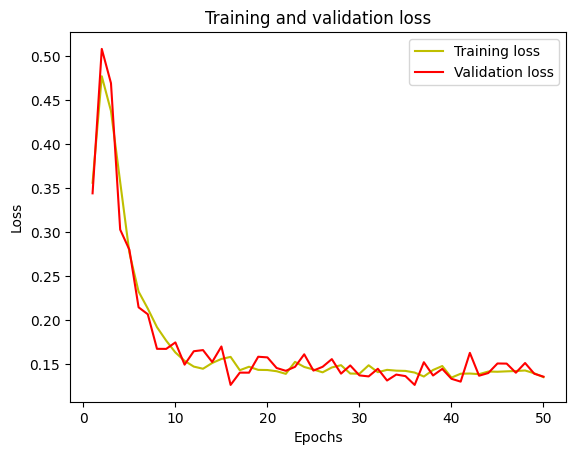

In [35]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()
plt.show()

## IOU

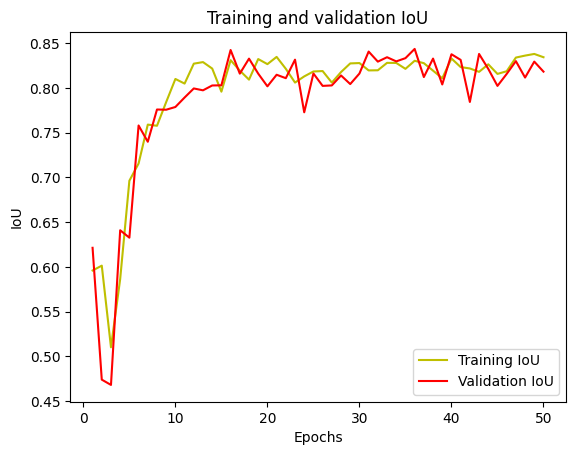

In [36]:
acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

### Accuracy

In [71]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


KeyError: 'accuracy'

### Accuracy

In [39]:
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix

model = load_model("Unetpp_LSTM_Dropout_Categorical_Cross_Entropy_Loss_1e4AdamSoftmax50_resnet34_NewAug_ReduceLRDiceCoeff.hdf5", compile=False)

test_image_batch, test_mask_batch = val_img_gen.__next__()


test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3)
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

# Calculate accuracy
accuracy = tf.keras.metrics.Accuracy()
accuracy.update_state(test_mask_batch_argmax, test_pred_batch_argmax)
print("Accuracy =", accuracy.result().numpy())

n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

# Flatten the arrays for classification report and confusion matrix
test_mask_flat = test_mask_batch_argmax.flatten()
test_pred_flat = test_pred_batch_argmax.flatten()

# Calculate and print the classification report
class_report = classification_report(test_mask_flat, test_pred_flat)
print("Classification Report:\n", class_report)

# Calculate and print the confusion matrix
conf_matrix = confusion_matrix(test_mask_flat, test_pred_flat)
print("Confusion Matrix:\n", conf_matrix)



1/1 [==============================] - 1s 654ms/step
Accuracy = 0.93694496
Mean IoU = 0.85873485
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.84      0.89    159793
           1       0.93      0.98      0.96    364495

    accuracy                           0.94    524288
   macro avg       0.94      0.91      0.92    524288
weighted avg       0.94      0.94      0.94    524288

Confusion Matrix:
 [[134064  25729]
 [  7330 357165]]


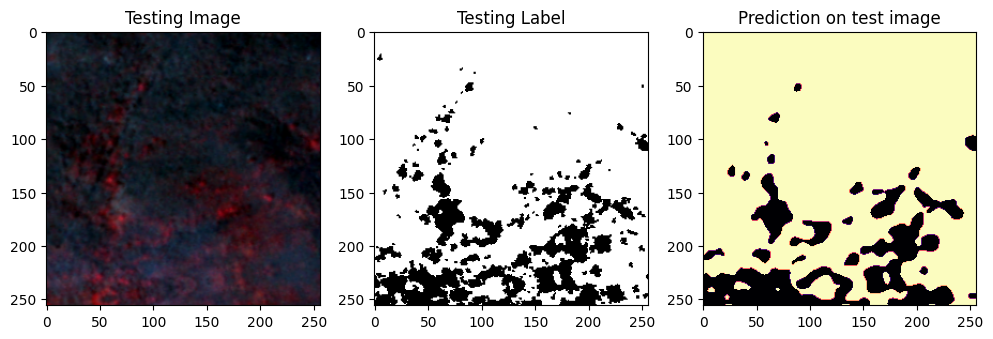

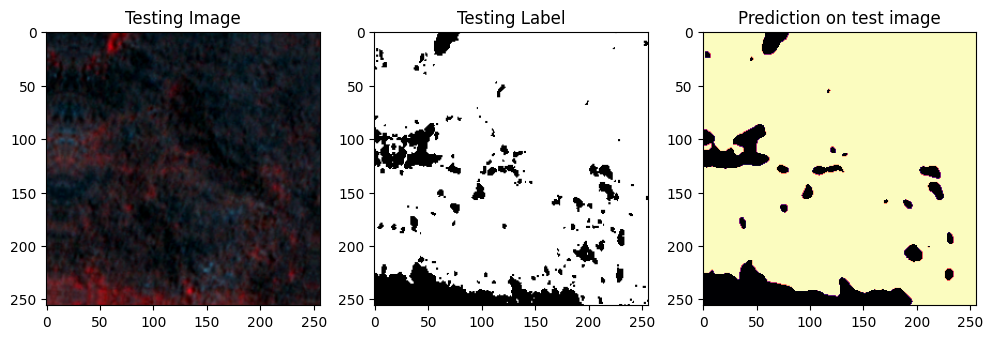

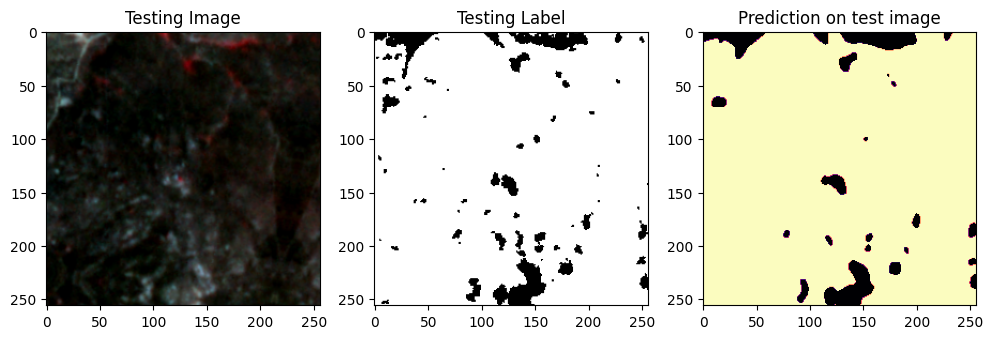

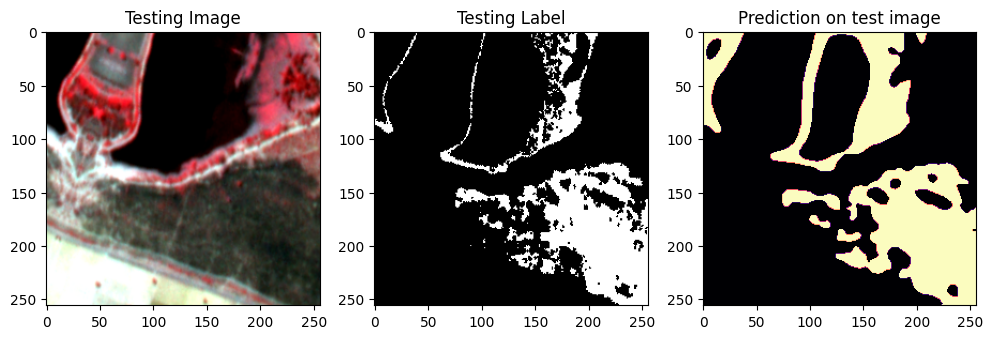

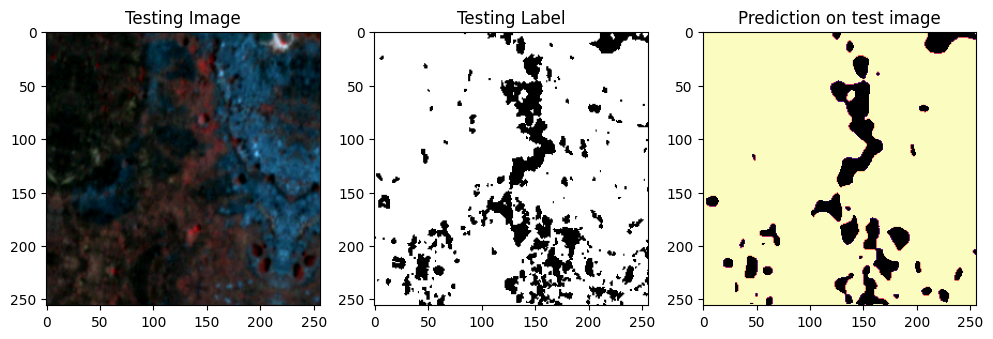

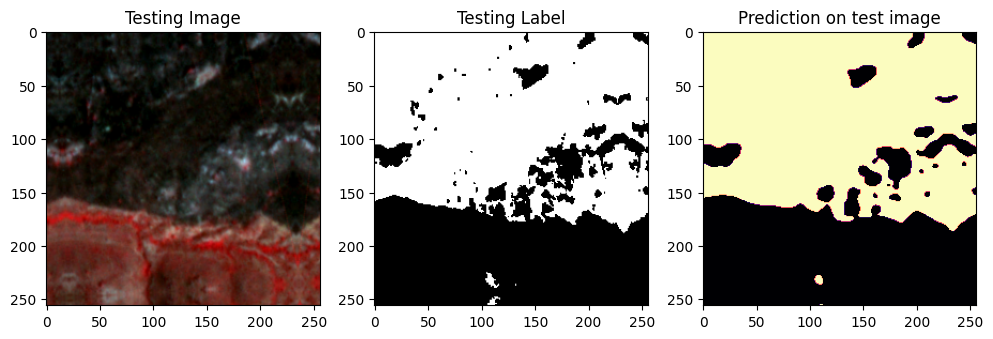

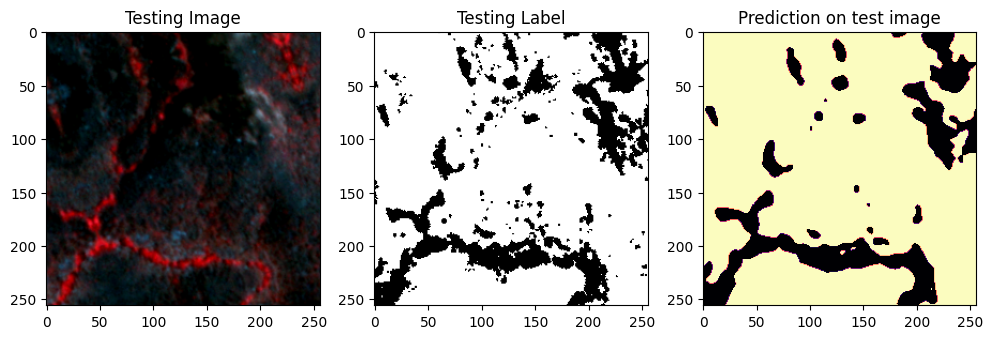

In [40]:
for x in range(0, test_image_batch.shape[0]-1):
    img_num=x
    plt.figure(figsize=(12, 8))
    plt.subplot(231)
    plt.title('Testing Image')
    plt.imshow(test_image_batch[img_num])
    
    plt.subplot(232)
    plt.title('Testing Label')

    plt.imshow(test_mask_batch_argmax[img_num],cmap='gray')
    plt.subplot(233)
    plt.title('Prediction on test image')
    plt.imshow(test_pred_batch_argmax[img_num],cmap='magma')
    plt.show()


In [42]:
import rasterio
import numpy as np


bands = ['B1.TIF', 'B2.TIF', 'B3.TIF', 'B4.TIF']

# Open the first band to get the metadata
with rasterio.open(bands[0]) as src:
    meta = src.meta

# Update the metadata to reflect the number of layers (bands)
meta.update(count=len(bands))

# Output file for the merged image
output_file = 'merged_landsat8.tif'

# Merge the bands into one multiband file
with rasterio.open(output_file, 'w', **meta) as dst:
    for i, band in enumerate(bands, start=1):
        with rasterio.open(band) as src:
            dst.write_band(i, src.read(1))

print(f'Merged image saved as {output_file}')


Merged image saved as merged_landsat8.tif
